In [1]:
import pandas as pd
import numpy as np

nba = pd.read_csv('nba_2013.csv', sep = ',')

nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


In [2]:
#Extract all point guards
point_guards = nba[nba['pos']=='PG']

In [3]:
#Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

#Calculate points per game
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Sanity check, make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head(5)

,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


In [4]:
#Drop people with 0 turnovers
point_guards = point_guards[point_guards['tov'] != 0]
#Calculate Assist Turnover Ratio
point_guards['atr'] =point_guards['ast'] /point_guards['tov']

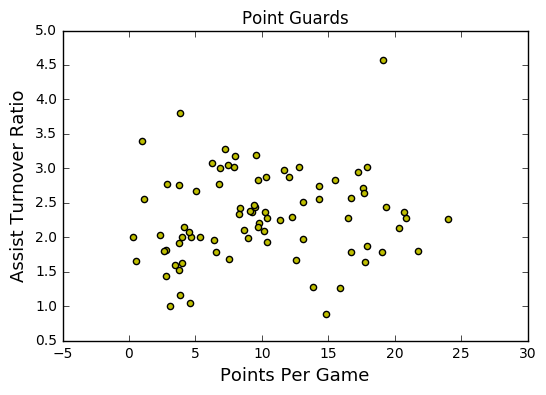

In [5]:
import matplotlib.pyplot as plt

#Plot Assist Turnover Ratio vs Points Per Game
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [6]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

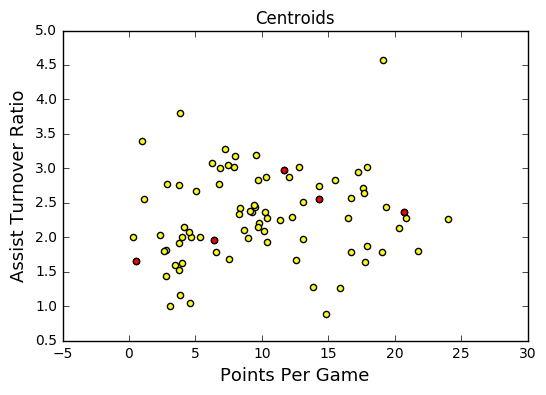

In [7]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='yellow')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [8]:
#Create dictionary to store centroids
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0
    #iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1
    return dictionary

centroids_dict = centroids_to_dict(centroids)

In [10]:
import math
#Calculate Euclidean distance between 2 vectors
def calculate_distance(centroid, player_values):
    root_distance = 0
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference
    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]
# Sqrt(5) = ~2.24

print(calculate_distance(q, p))

2.23606797749979


In [11]:
# Add the function, `assign_to_cluster`, which assigns to cluster according to min Euclidean distance
# This creates the column, `cluster`, by applying assign_to_cluster row-by-row

def assign_to_cluster(player):
    distances = []
    for centroid in centroids_dict.values():
        distance = calculate_distance(centroid, [player['ppg'], player['atr']])
        distances.append(distance)
    return (np.argmin(distances))

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

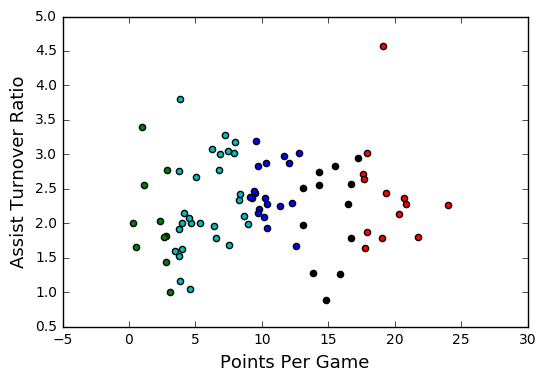

In [12]:
# Create function to visualize clusters

def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

In [13]:
#Function to recalculate centroids as average of each cluster
def recalculate_centroids(df):
    new_centroids_dict = dict()
    # 0..1...2...3...4
    for cluster_id in range(0, num_clusters):
        # Finish the logic
        players = df[point_guards['cluster'] == cluster_id]
        new_ppg = np.mean(players['ppg'])
        new_atr = np.mean(players['atr'])
        new_centroids_dict[cluster_id] = [new_ppg, new_atr]
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

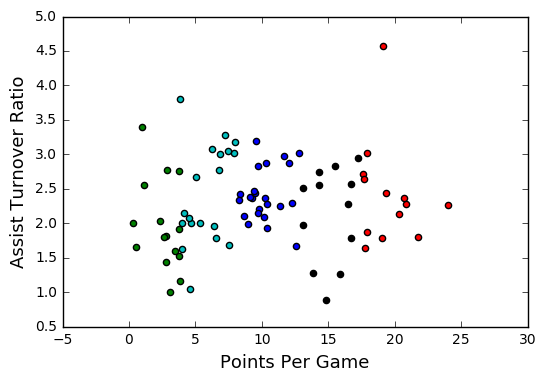

In [14]:
#Reassign players to clusters
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

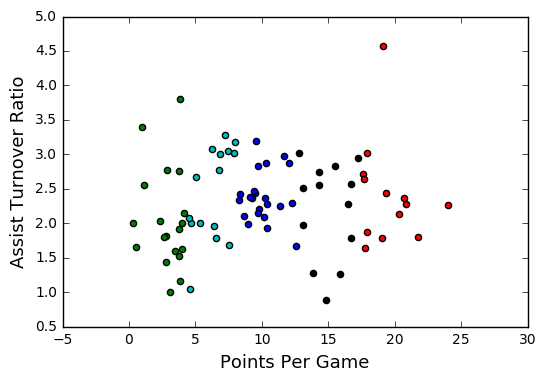

In [16]:

#Recalculate centroids and reassign players to clusters
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

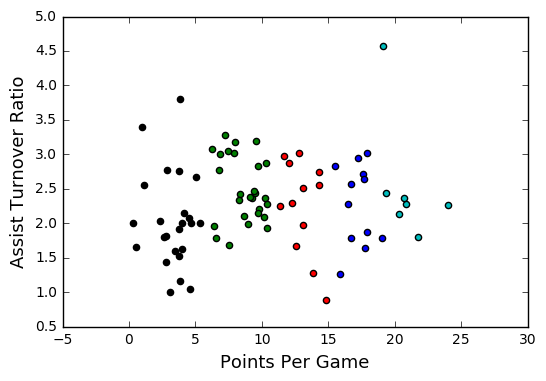

In [17]:
#Use sklearn k-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)